In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
########################   读取数据  #########################################
sheet = pd.read_excel('data_input/中国10债Non-Trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
full_date_range = pd.date_range(start=sheet.index.min(), end=sheet.index.max()+pd.Timedelta(days=60), freq='D')
sheet = sheet.reindex(full_date_range)
sheet = sheet.reset_index().rename(columns={'index': 'Date'})

sheet.set_index('Date', inplace=True)
sheet = sheet.resample('ME').last()
last_day = sheet['中国10年期国债收益率Non-Trend/F0.2'].last_valid_index()
sheet = sheet.reset_index()

sheet_daily = sheet.copy()

sheet_daily['10年期美国国债收益率80日环差_提前80天'] = sheet_daily['10年期美国国债收益率80日环差'].shift(4)
sheet_daily['南华工业品指数80日环比_提前55天'] = sheet_daily['南华工业品指数80日环比'].shift(3)
sheet_daily['新增人民币贷款/中长期同差_提前160天'] = sheet_daily['新增人民币贷款/中长期同差'].shift(8)
sheet_daily['M2同比_提前140天'] = sheet_daily['M2同比'].shift(7)
sheet_daily['M1同比_提前60天'] = sheet_daily['M1同比'].shift(3)

sheet_daily= sheet_daily[sheet_daily['Date'] >= '2020-01-01'] 

sheet_daily['10年期美国国债收益率80日环差_提前80天_2023-01-01之后'] = sheet_daily['10年期美国国债收益率80日环差_提前80天'].loc[sheet_daily['Date'] >= '2023-01-01']
sheet_daily['南华工业品指数80日环比_提前55天_2022-11-01之后'] = sheet_daily['南华工业品指数80日环比_提前55天'].loc[sheet_daily['Date'] >= '2022-11-01']

In [4]:
sheet

,Date,中国10年期国债收益率Non-Trend/F0.2,10年期美国国债收益率80日环差,南华工业品指数80日环比,新增人民币贷款/中长期同差,M2同比,M1同比
0,1991-12-31,NaN,NaN,NaN,NaN,26.5,24.2
1,1992-01-31,NaN,NaN,NaN,NaN,NaN,NaN
2,1992-02-29,NaN,-0.20,NaN,NaN,NaN,NaN
3,1992-03-31,NaN,0.37,NaN,NaN,NaN,NaN
4,1992-04-30,NaN,0.79,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
395,2024-11-30,-0.0804,0.40,-0.0212,-1691.0,7.1,-3.7
396,2024-12-31,-0.4034,0.81,-0.0052,-6674.0,7.3,-1.4
397,2025-01-31,-0.4614,0.88,0.0840,NaN,NaN,NaN
398,2025-02-28,NaN,NaN,NaN,NaN,NaN,NaN


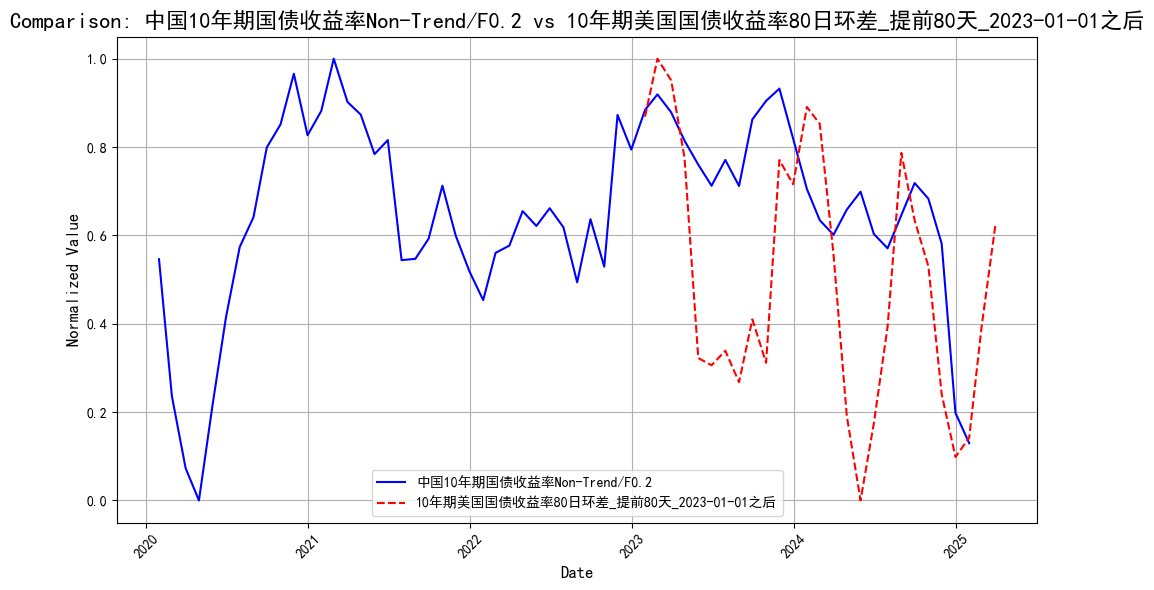

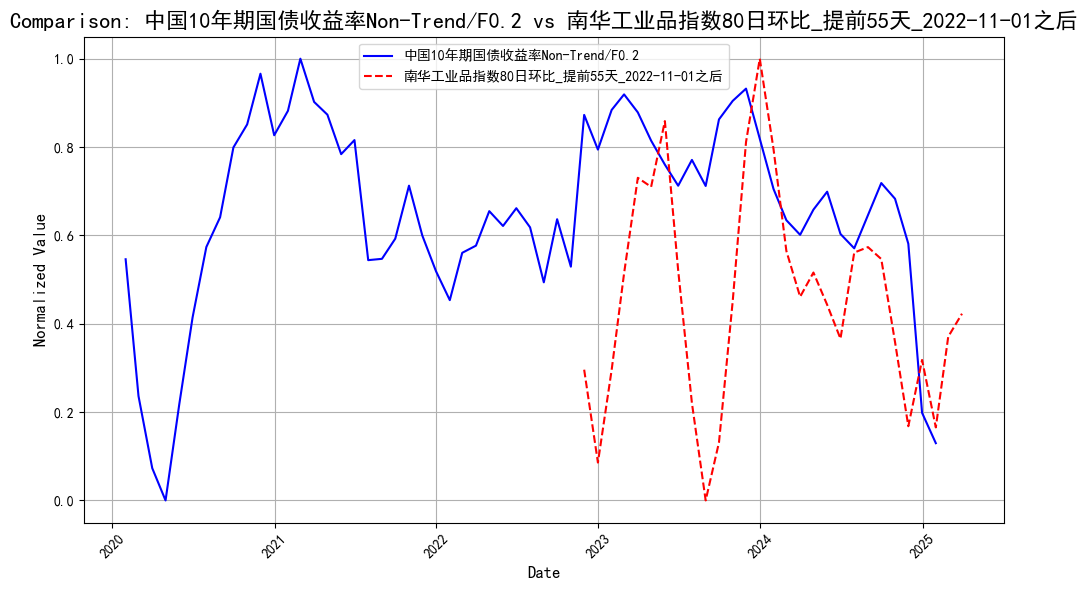

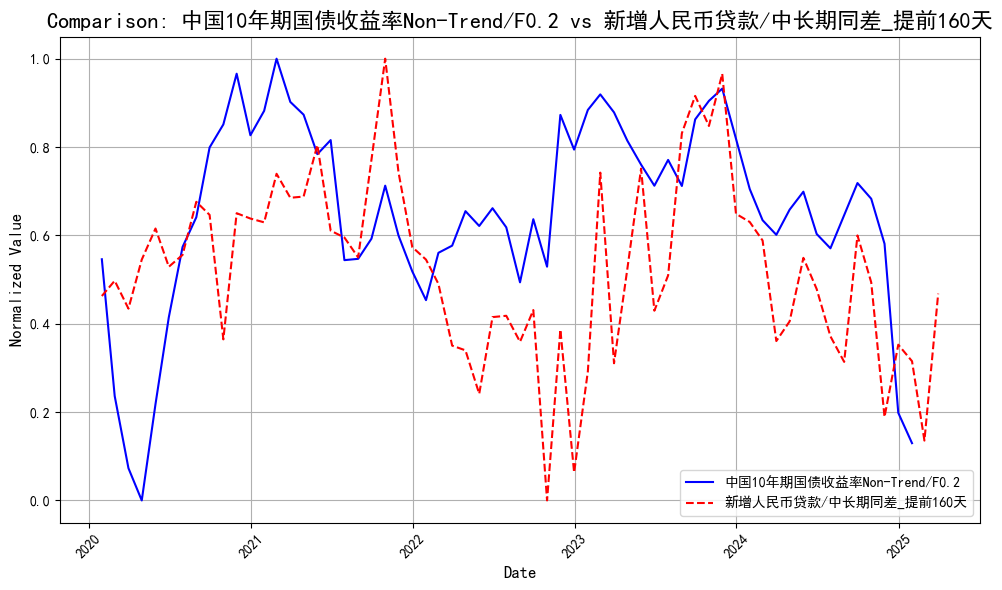

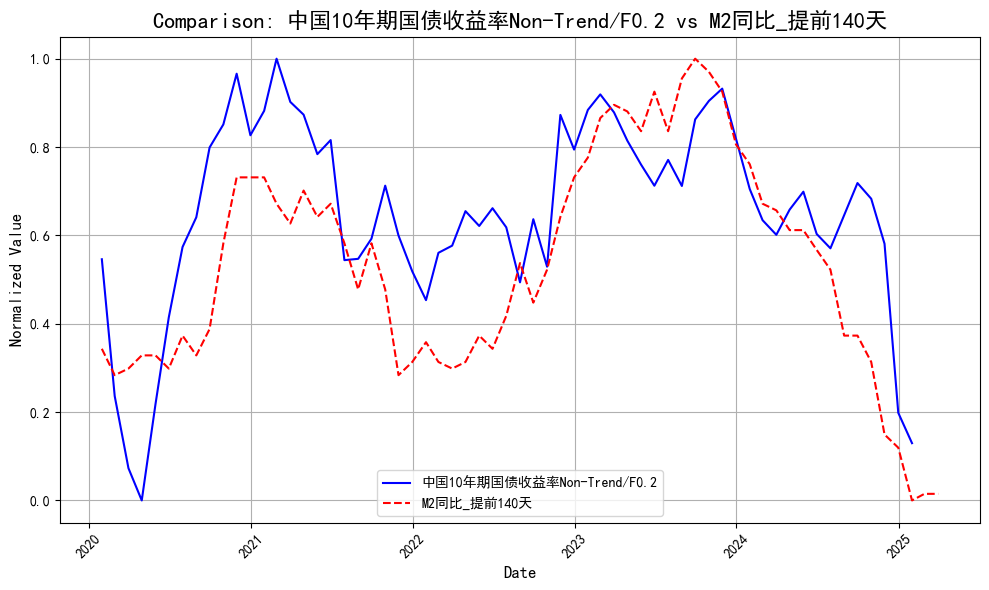

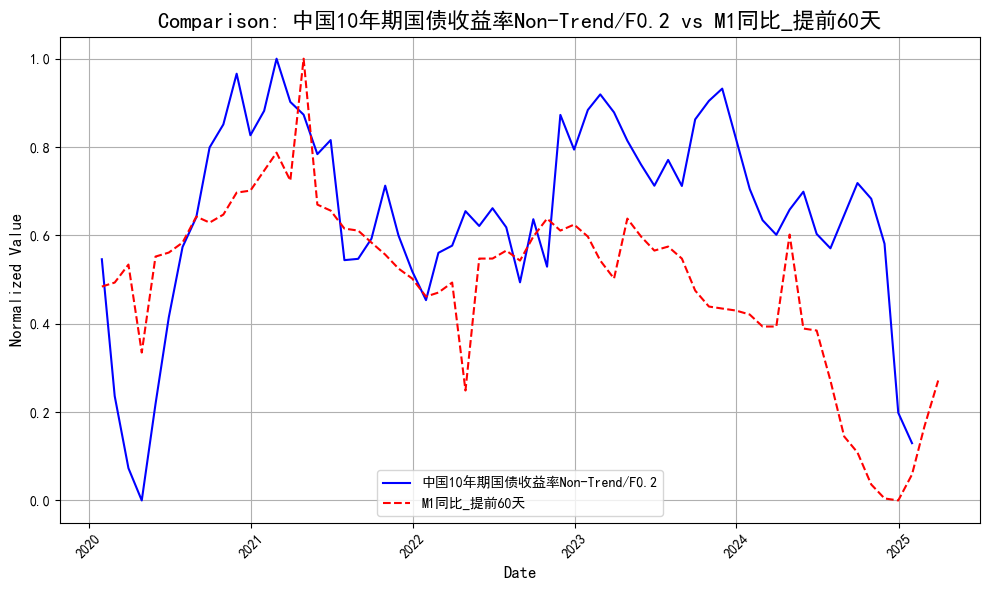

In [5]:
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='中国10年期国债收益率Non-Trend/F0.2', 
    compare_cols=[ '10年期美国国债收益率80日环差_提前80天_2023-01-01之后','南华工业品指数80日环比_提前55天_2022-11-01之后','新增人民币贷款/中长期同差_提前160天','M2同比_提前140天','M1同比_提前60天']
)

In [34]:
# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 8
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]


In [35]:
feature_columns = [
    #'10年期美国国债收益率80日环差_提前80天_2023-01-01之后',
    #'南华工业品指数80日环比_提前55天_2022-11-01之后',
    '新增人民币贷款/中长期同差_提前160天',
    'M2同比_提前140天',
    'M1同比_提前60天'
]

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data['中国10年期国债收益率Non-Trend/F0.2']

X_test = test_data[feature_columns]
y_test = test_data['中国10年期国债收益率Non-Trend/F0.2']

X_future = future_data[feature_columns]

In [36]:
# 创建并训练决策树回归模型
from sklearn.tree import DecisionTreeRegressor

# 增加模型复杂度的参数
model = DecisionTreeRegressor(
    random_state=42,
    max_depth=8,  # 增加树的深度
    min_samples_split=5,  # 减少分裂所需的最小样本数
    min_samples_leaf=3,  # 减少叶节点所需的最小样本数
    max_features='sqrt'  # 在每次分裂时考虑的特征数量为总特征数的平方根
)

model.fit(X_train, y_train)

# 对训练集进行预测
y_train_pred = model.predict(X_train)

# 对测试集进行预测
y_test_pred = model.predict(X_test)

# 对未来数据进行预测
y_future_pred = model.predict(X_future)

# 计算训练集和测试集的R方分数
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f'训练集 R² 分数: {train_score:.4f}')
print(f'测试集 R² 分数: {test_score:.4f}')




训练集 R² 分数: 0.6977
测试集 R² 分数: 0.1309


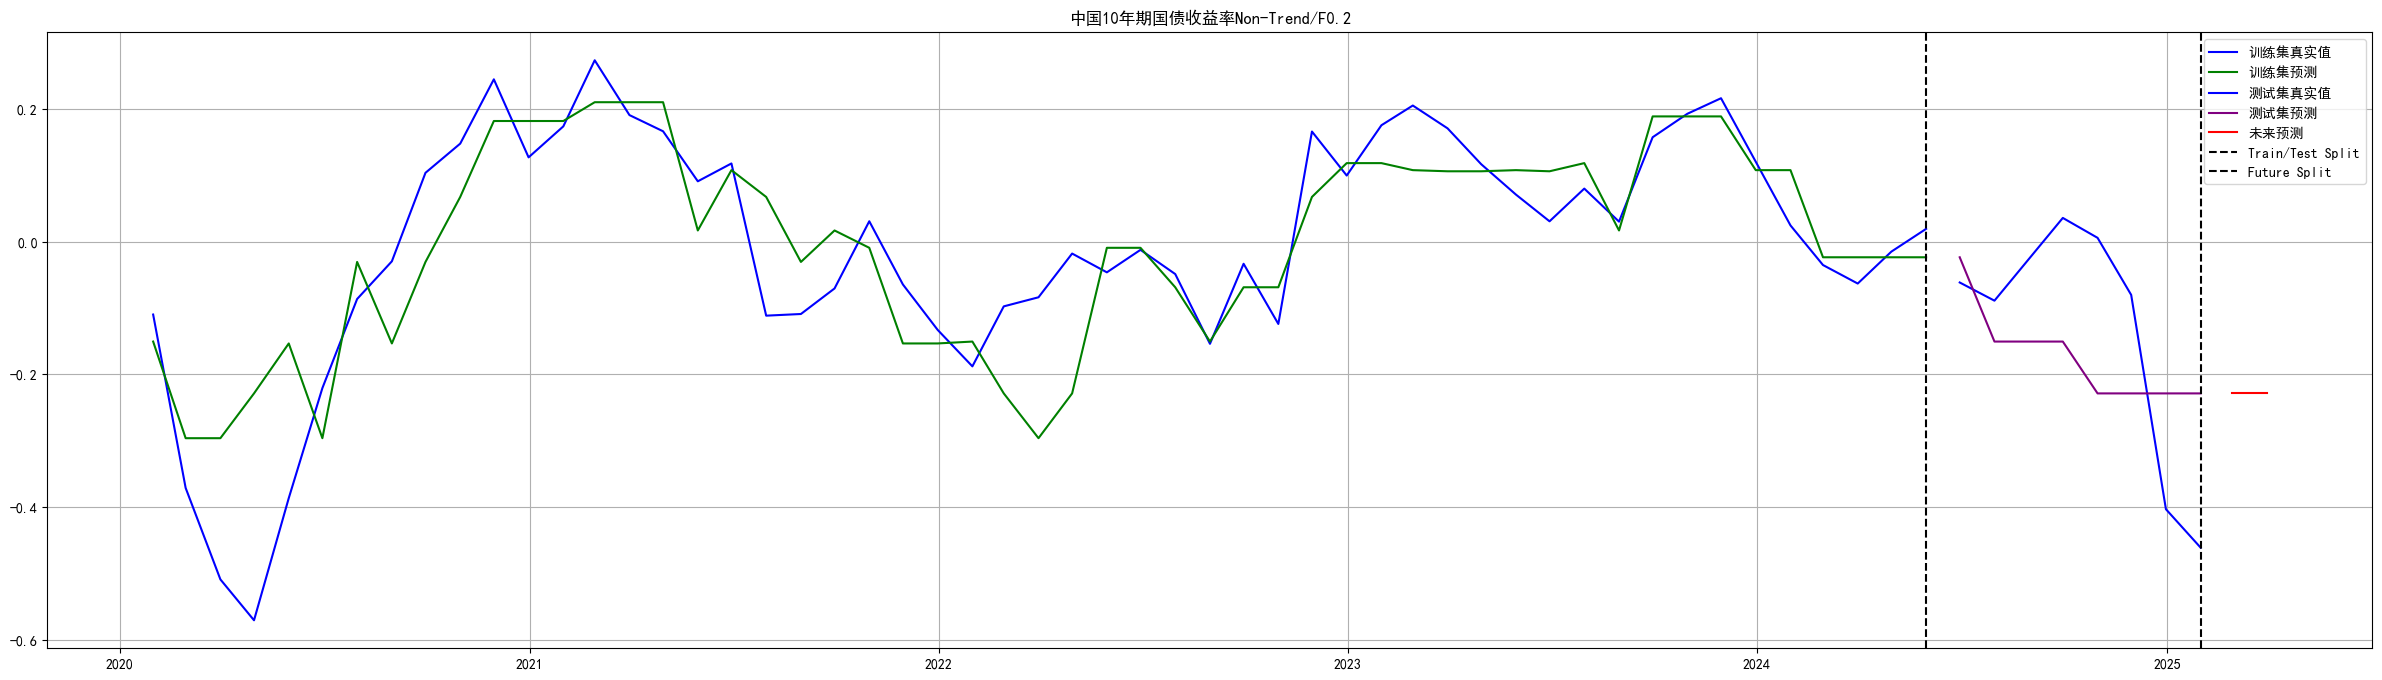

In [37]:
plt.figure(figsize=(30, 8))
plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue')
plt.plot(test_data['Date'], y_test_pred, label='测试集预测', color='purple')
plt.plot(future_data['Date'], y_future_pred, label='未来预测', color='red')

plt.axvline(x=train_data['Date'].iloc[-1], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')


plt.title('中国10年期国债收益率Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()
